## Testing the ability to distinguish signal events from background

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

In [3]:
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))

In [4]:
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))

In [5]:
time = numpy.vstack((hits.get_measurement(i,"CdcCell_t")%1170- hits.get_trigger_time(i))%1170  for i in range(hits.n_events))

In [6]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Preapring features

In [7]:
# to avoid small numbers for GBRT
deposits *= 100

In [8]:
# get sum of desposits of neighbours 
avn_deposits = hits.cydet.point_neighbours.dot(deposits.T).T
# get count
avn_deposits_count = hits.cydet.point_neighbours.dot(deposits.T > 0).T

In [9]:
avn_deposits2 = hits.cydet.point_neighbours.dot(avn_deposits.T).T

## Train/test splitting 

In [10]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(len(labels)), train_size=0.05, test_size=0.05)

In [11]:
from collections import OrderedDict
features = OrderedDict()
features['deposit'] = deposits * 100
features['av_deposit'] = avn_deposits * 100
features['av_deposits_count'] = avn_deposits_count
features['av_deposits_twice'] = avn_deposits2
features['time'] = time
features['labels'] = labels

In [12]:
train_features = features.keys()[:-1]

In [13]:
data = numpy.dstack(features.values())

In [14]:
data.shape

(3445, 4482, 6)

In [15]:
n_feats = data.shape[-1]
train_data, test_data = data[train_events].reshape(-1, n_feats), data[test_events].reshape(-1, n_feats)

In [16]:
import pandas
train_data = pandas.DataFrame(data=train_data, columns=features.keys())
test_data = pandas.DataFrame(data=test_data, columns=features.keys())

In [17]:
train_data = train_data[train_data['labels'] != 0]
test_data = test_data[test_data['labels'] != 0]

train_data['labels'] = 2 - train_data['labels']
test_data['labels'] = 2 - test_data['labels']

## Using simple GBRT to determine if wire is signal

In [18]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
factory = ClassifiersFactory()
gb_all_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=40), 
                                    features=train_features)
gb_deposit = SklearnClassifier(GradientBoostingClassifier(n_estimators=40), 
                               features=['deposit'])
factory.add_classifier('gb', gb_all_features)
factory.add_classifier('gb_deposit', gb_deposit)

In [20]:
factory.fit(train_data, train_data['labels'])
pass

model gb           was trained in 4.93 seconds
model gb_deposit   was trained in 1.61 seconds
Totally spent 6.54 seconds on training


In [21]:
predictions = factory.test_on(test_data, test_data['labels'])

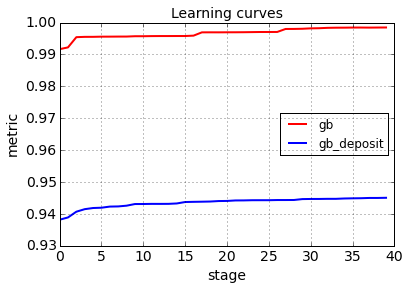

In [22]:
from rep.report.metrics import RocAuc
predictions.learning_curve(RocAuc(), steps=1)

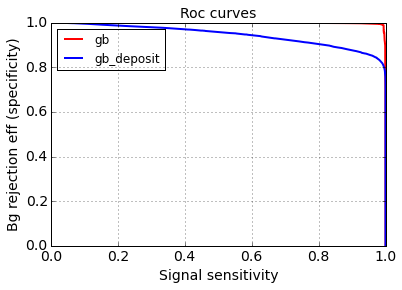

In [23]:
predictions.roc()

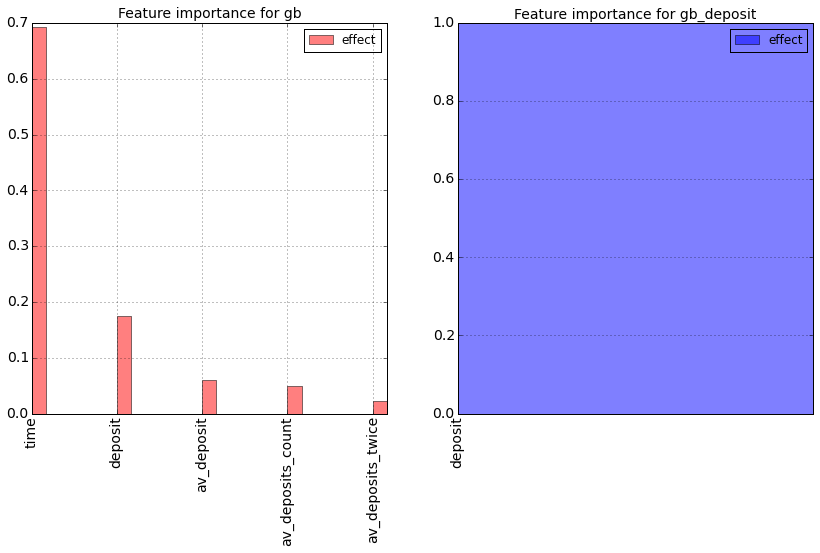

In [24]:
predictions.feature_importance().plot(figsize=[14, 7])

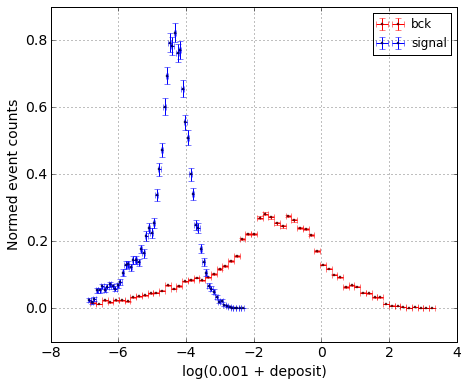

In [25]:
predictions.features_pdf(features=['log(0.001 + deposit)'], bins=60)

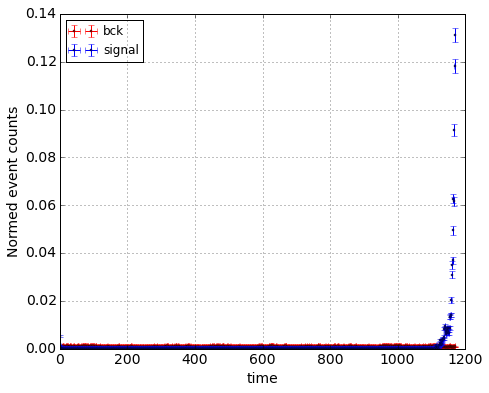

In [26]:
predictions.features_pdf(features=['time'], bins=1000)